# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [42]:
import io
import os
import numpy as np
import scipy

from matplotlib import pyplot as plt


plt.rcParams['figure.figsize'] = (6.4 * 2, 4.8 * 2)
plt.rcParams['font.size'] = 18

In [2]:
PATH_TO_DATA = "./data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=-1):
        self.word2vec = self.load_wordvec(fname, nmax)
        self.word2id = {w: i for i, w in enumerate(self.word2vec.keys())}
        self.id2word = {i: w for w, i in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values()))
        
    def load_wordvec(self, fname, nmax):
        word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                word2vec[word] = np.fromstring(vec, sep=' ')
                # Normalize vectors once and for all
                word2vec[word] /= np.linalg.norm(word2vec[word])
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(word2vec)))
        
        return word2vec

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        
        v = self.get_vec(w)
        
        scores = np.dot(self.embeddings, v)
        desc_scores_idx = np.argsort(scores)[::-1]
        
        return [
            self.id2word[i]
            for i in desc_scores_idx[1:(K + 1)]
        ]

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        v1 = self.get_vec(w1)
        v2 = self.get_vec(w2)
        return np.dot(v1.T, v2) 
    
    def get_vec(self, w):
        """
        Return embedding associated with word w
        """
        return self.embeddings[self.word2id[w]]


In [7]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'))

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'Paris', 'Germany'), ('dog', 'pet', 'cats', 'France', 'Berlin')):
    print(f'Score between "{w1}" and "{w2}":', w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(f'Most similar to "{w1}":', w2v.most_similar(w1))

Loaded 200000 pretrained word vectors
Score between "cat" and "dog": 0.671683666279249
Score between "dog" and "pet": 0.6842064029669219
Score between "dogs" and "cats": 0.7074389328052404
Score between "Paris" and "France": 0.7058595452409975
Score between "Germany" and "Berlin": 0.7060253015336015
Most similar to "cat": ['cats', 'kitty', 'kitten', 'feline', 'kitties']
Most similar to "dog": ['dogs', 'puppy', 'Dog', 'doggie', 'canine']
Most similar to "dogs": ['dog', 'pooches', 'Dogs', 'doggies', 'canines']
Most similar to "Paris": ['Parisian', 'France', 'paris', 'PARIS', 'Montmartre']
Most similar to "Germany": ['Austria', 'Bavaria', 'Berlin', 'Munich', 'germany']


In [8]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                mean = np.mean([
                    self.w2v.get_vec(w)
                    for w in sent
                    if w in self.w2v.word2vec
                ], axis=0)
            else:
                # idf-weighted mean of word vectors
                mean = np.mean([
                    idf[w] * self.w2v.get_vec(w)
                    for w in sent
                    if w in self.w2v.word2vec
                ], axis=0)
            
            sentemb.append(mean / np.linalg.norm(mean))
        
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)[0]
        
        scores = np.dot(keys, query)
        desc_scores_idx = np.argsort(scores)[::-1]
        
        # The most similar sentence is the one with second best score (self-similarity is always 1)
        most_similar_sent = [
            sentences[desc_scores_idx[i]]
            for i in range(1, K + 1)
        ]
        
        S = ' '.join(s)
        print(f'{K} most similar sentences to "{S}":')
        for sent in most_similar_sent:
            S = ' '.join(sent)
            print(f'- "{S}"')
        
        return most_similar_sent

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        vecs = self.encode([s1, s2])
        score = np.dot(vecs[0].T, vecs[1])
        
        S1 = ' '.join(s1)
        S2 = ' '.join(s2)
        print(f'Score between "{S1}" and "{S2}": {score}')
        
        return score
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        
        for w in idf:
            idf[w] = np.log10(len(sentences) / idf[w])
        
        return idf


In [11]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'))
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with open(os.path.join(PATH_TO_DATA, 'sentences.txt'), 'r') as f:
    sentences = [
        s.split()
        for s in f.readlines()
    ]

# You will be evaluated on the output of the following:
s2v.most_similar(sentences[10], sentences)  # BoV-mean
print()

s2v.score(sentences[7], sentences[13])
print()


# Build idf scores for each word
idf = s2v.build_idf(sentences)

s2v.most_similar(sentences[10], sentences, idf)  # BoV-idf
print()

s2v.score(sentences[7], sentences[13], idf)
print()

Loaded 200000 pretrained word vectors
5 most similar sentences to "1 smiling african american boy .":
- "an african american man smiling ."
- "a little african american boy and girl looking up ."
- "a girl in black hat holding an african american baby ."
- "an afican american woman standing behind two small african american children ."
- "african american woman putting braids in an adorable asian girls hair ."

Score between "1 man singing and 1 man playing a saxophone in a concert ." and "10 people venture out to go crosscountry skiing .": 0.6224503370327624

5 most similar sentences to "1 smiling african american boy .":
- "an african american man smiling ."
- "2 african adults and 8 african children looking at pictures on a table ."
- "an african american man is sitting ."
- "a girl in black hat holding an african american baby ."
- "a little african american boy and girl looking up ."

Score between "1 man singing and 1 man playing a saxophone in a concert ." and "10 people venture

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [12]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec
    
fasttext_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)
fasttext_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [13]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

vocab_fr = set(fasttext_fr.word2vec.keys())
vocab_en = set(fasttext_en.word2vec.keys())

common_vocab = sorted(vocab_fr & vocab_en)
print(f'{len(common_vocab)} common words')

X = np.vstack([
    fasttext_fr.get_vec(word)
    for word in common_vocab
]).T

Y = np.vstack([
    fasttext_en.get_vec(word)
    for word in common_vocab
]).T

18970 common words


In [14]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

import scipy.linalg

U, s, Vh = scipy.linalg.svd(np.dot(Y, X.T))

W = np.dot(U, Vh)

In [15]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

def most_similar_fr_to_en(fr, en, W, w, K=5):
    # K most similar words: self.score  -  np.argsort 

    v_fr = fr.get_vec(w)
    v_en = np.dot(W, v_fr)

    scores = np.dot(en.embeddings, v_en)
    desc_scores_idx = np.argsort(scores)[::-1]

    return [
        en.id2word[i]
        for i in desc_scores_idx[:K]
    ]


def most_similar_en_to_fr(fr, en, W, w, K=5):
    # K most similar words: self.score  -  np.argsort 

    v_en = en.get_vec(w)
    v_fr = np.dot(W.T, v_en)

    scores = np.dot(fr.embeddings, v_fr)
    desc_scores_idx = np.argsort(scores)[::-1]

    return [
        fr.id2word[i]
        for i in desc_scores_idx[:K]
    ]


print(most_similar_fr_to_en(fasttext_fr, fasttext_en, W, 'poisson'))
print(most_similar_en_to_fr(fasttext_fr, fasttext_en, W, 'fish'))

print(most_similar_fr_to_en(fasttext_fr, fasttext_en, W, 'bureau'))
print(most_similar_en_to_fr(fasttext_fr, fasttext_en, W, 'desk'))

print(most_similar_fr_to_en(fasttext_fr, fasttext_en, W, 'camionnette'))
print(most_similar_en_to_fr(fasttext_fr, fasttext_en, W, 'truck'))

print(most_similar_fr_to_en(fasttext_fr, fasttext_en, W, 'salaire'))
print(most_similar_en_to_fr(fasttext_fr, fasttext_en, W, 'salary'))

print(most_similar_fr_to_en(fasttext_fr, fasttext_en, W, 'développement'))
print(most_similar_fr_to_en(fasttext_fr, fasttext_en, W, 'séries'))
print(most_similar_fr_to_en(fasttext_fr, fasttext_en, W, 'portrait'))

['mackerel', 'fish', 'shrimp', 'lobster', 'eel']
['poissons', 'fish', 'crevettes', 'crustacés', 'truites']
['bureau', 'bureaus', 'office', 'offices', 'secretariat']
['desk', 'room', 'please', 'placard', 'talk']
['truck', 'limousine', 'jeep', 'trucks', 'car']
['camionnette', 'camion', 'truck', 'voiture', 'jeep']
['salary', 'salaries', 'wages', 'wage', 'payroll']
['salaire', 'rémunération', 'salaires', 'rémunérations', 'rémunéré']
['development', 'developing', 'commercialization', 'growth', 'diversification']
['series', 'episodes', 'specials', 'sitcoms', 'serials']
['portrait', 'portraits', 'portraiture', 'painting', 'paintings']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [16]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def load_sst(fname, with_labels=True):
    X = []
    y = []
    with open(fname, 'r') as f:
        for s in f.readlines():
            if with_labels:
                c, sentence = s.split(' ', 1)
                y.append(int(c))
            else:
                sentence = s
                
            X.append(sentence.split())
            
    if not with_labels:
        return X
    
    return X, y

S_train, y_train = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.train'))
S_dev, y_dev = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.dev'))
S_test = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.test.X'), with_labels=False)

In [23]:
# 2 - Encode sentences with the BoV model above

idf = s2v.build_idf(S_train + S_dev + S_test)
# idf = False

X_train = s2v.encode(S_train, idf)
X_dev = s2v.encode(S_dev, idf)
X_test = s2v.encode(S_test, idf)

In [24]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score


logreg = LogisticRegressionCV(cv=3, random_state=42, multi_class='multinomial', solver='lbfgs', max_iter=1000)

logreg.fit(X_train, y_train)

print(f'Training accuracy: {accuracy_score(y_train, logreg.predict(X_train))}')
print(f'Dev accuracy: {accuracy_score(y_dev, logreg.predict(X_dev))}')

Training accuracy: 0.4827949438202247
Dev accuracy: 0.4405086285195277


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

y_test_pred = logreg.predict(X_test)

with open('logreg_bov_y_test_sst.txt', 'w') as f:
    f.writelines([
        f'{y}\n'
        for y in y_test_pred
    ])

In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score


gbm = LGBMClassifier(
    n_jobs=8, 
    n_estimators=500,
)

gbm.fit(X_train, y_train, verbose=True, eval_set=[(X_dev, y_dev)], early_stopping_rounds=10)

y_pred = gbm.predict(X_dev)

accuracy_score(y_dev, y_pred)

[1]	valid_0's multi_logloss: 1.55632
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 1.54093
[3]	valid_0's multi_logloss: 1.52967
[4]	valid_0's multi_logloss: 1.51844
[5]	valid_0's multi_logloss: 1.50612
[6]	valid_0's multi_logloss: 1.49636
[7]	valid_0's multi_logloss: 1.48727
[8]	valid_0's multi_logloss: 1.47798
[9]	valid_0's multi_logloss: 1.47062
[10]	valid_0's multi_logloss: 1.4649
[11]	valid_0's multi_logloss: 1.46038
[12]	valid_0's multi_logloss: 1.45391
[13]	valid_0's multi_logloss: 1.44858
[14]	valid_0's multi_logloss: 1.44107
[15]	valid_0's multi_logloss: 1.4365
[16]	valid_0's multi_logloss: 1.43264
[17]	valid_0's multi_logloss: 1.42648
[18]	valid_0's multi_logloss: 1.4218
[19]	valid_0's multi_logloss: 1.41656
[20]	valid_0's multi_logloss: 1.41319
[21]	valid_0's multi_logloss: 1.40938
[22]	valid_0's multi_logloss: 1.40665
[23]	valid_0's multi_logloss: 1.4024
[24]	valid_0's multi_logloss: 1.39837
[25]	valid_0's multi_logloss: 1.39532
[

0.41689373297002724

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [25]:
import keras

Using TensorFlow backend.


In [26]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./data/"

def load_sst(fname, with_labels=True):
    X = []
    y = []
    with open(fname, 'r') as f:
        for s in f.readlines():
            if with_labels:
                c, sentence = s.split(' ', 1)
                y.append(int(c))
            else:
                sentence = s
                
            X.append(sentence.strip())
            
    if not with_labels:
        return X
    
    return X, y

S_train, y_train = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.train'))
S_dev, y_dev = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.dev'))
S_test = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.test.X'), with_labels=False)

In [27]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

vocab_size = 5000  # size of the vocabulary

Si_train = [
    keras.preprocessing.text.one_hot(s, vocab_size)
    for s in S_train
]
Si_dev = [
    keras.preprocessing.text.one_hot(s, vocab_size)
    for s in S_dev
]
Si_test = [
    keras.preprocessing.text.one_hot(s, vocab_size)
    for s in S_test
]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [28]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

max_size = 200

X_train = keras.preprocessing.sequence.pad_sequences(Si_train, maxlen=max_size)
X_dev = keras.preprocessing.sequence.pad_sequences(Si_dev, maxlen=X_train.shape[1])
X_test = keras.preprocessing.sequence.pad_sequences(Si_test, maxlen=X_train.shape[1])

## 4.2 - Design and train your model

In [33]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
n_classes  = 5

model = Sequential([
    Embedding(vocab_size, embed_dim),
    LSTM(nhid, dropout=0.2, recurrent_dropout=0.2),
    Dense(n_classes, activation='softmax'),
])


In [34]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 185,157
Trainable params: 185,157
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
from keras.callbacks import EarlyStopping


bs = 16
n_epochs = 10

y_train_hot = keras.utils.to_categorical(y_train, num_classes=n_classes)
y_dev_hot = keras.utils.to_categorical(y_dev, num_classes=n_classes)

early_stopping = EarlyStopping(
    monitor='val_acc',  # go through epochs as long as accuracy on validation set increases
    patience=2,
    mode='max',
)

history = model.fit(
    X_train, y_train_hot, 
    batch_size=bs, epochs=n_epochs, 
    validation_data=(X_dev, y_dev_hot), 
    callbacks=[early_stopping],
)

Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 104s 12ms/step - loss: 1.5474 - acc: 0.2973 - val_loss: 1.4573 - val_acc: 0.3606
Epoch 2/10
8544/8544 [==============================] - 104s 12ms/step - loss: 1.3372 - acc: 0.4189 - val_loss: 1.4235 - val_acc: 0.3878
Epoch 3/10
8544/8544 [==============================] - 104s 12ms/step - loss: 1.1349 - acc: 0.5342 - val_loss: 1.5081 - val_acc: 0.3579
Epoch 4/10
8544/8544 [==============================] - 104s 12ms/step - loss: 0.9706 - acc: 0.6179 - val_loss: 1.6616 - val_acc: 0.3588


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


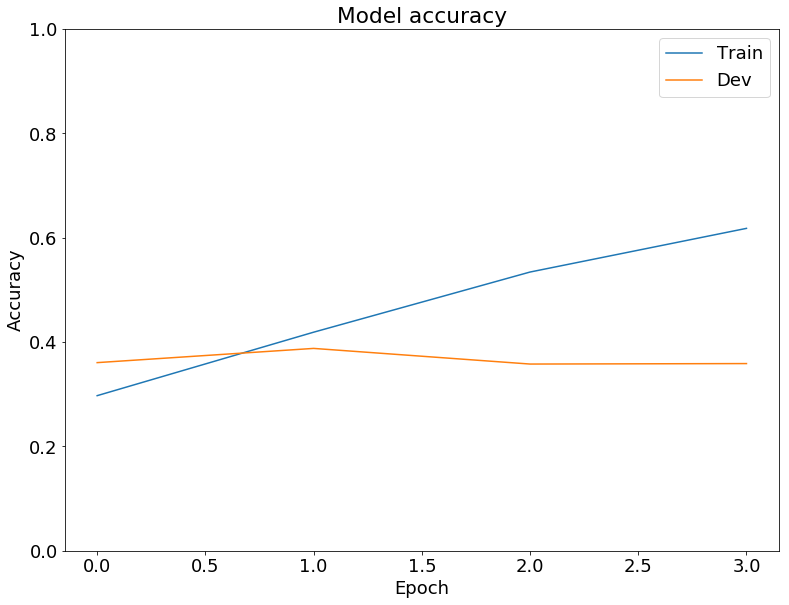

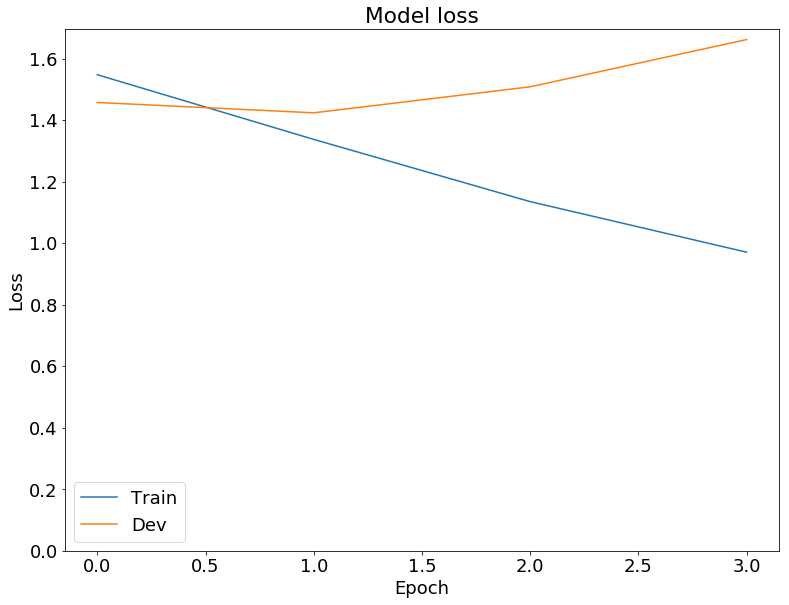

In [45]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Dev')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 1)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Dev')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, None)
plt.show()

# Writing test predictions
y_test_pred = model.predict(X_test)

with open('logreg_lstm_y_test_sst.txt', 'w') as f:
    f.writelines([
        f'{y}\n'
        for y in np.argmax(y_test_pred, axis=1)
    ])

## 4.3 -- innovate !

In [51]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Activation, Conv1D, MaxPooling1D

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'))

S_train, y_train = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.train'))
S_dev, y_dev = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.dev'))
S_test = load_sst(os.path.join(PATH_TO_DATA, 'SST', 'stsa.fine.test.X'), with_labels=False)

print(w2v.id2word[0], w2v.id2word[1])

Si_train = [
    [w2v.word2id.get(w, 1) for w in s.split(' ')]
    for s in S_train
]
Si_dev = [
    [w2v.word2id.get(w, 1) for w in s.split(' ')]
    for s in S_dev
]
Si_test = [
    [w2v.word2id.get(w, 1) for w in s.split(' ')]
    for s in S_test
]

max_size = 200

X_train = keras.preprocessing.sequence.pad_sequences(Si_train, maxlen=max_size)
X_dev = keras.preprocessing.sequence.pad_sequences(Si_dev, maxlen=X_train.shape[1])
X_test = keras.preprocessing.sequence.pad_sequences(Si_test, maxlen=X_train.shape[1])

n_classes = 5

model = Sequential([
    Embedding(
        input_dim=w2v.embeddings.shape[0], 
        output_dim=w2v.embeddings.shape[1], 
        weights=[w2v.embeddings],
        trainable=False,
    ),
    Dropout(0.3),
    Conv1D(32, 5, activation='relu'),
    MaxPooling1D(4),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(n_classes, activation='softmax'),
])

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

bs = 32
n_epochs = 15

y_train_hot = keras.utils.to_categorical(y_train, num_classes=n_classes)
y_dev_hot = keras.utils.to_categorical(y_dev, num_classes=n_classes)

early_stopping = EarlyStopping(
    monitor='val_loss',  # go through epochs as long as accuracy on validation set increases
    patience=2,
    mode='min',
)

history = model.fit(
    X_train, y_train_hot, 
    batch_size=bs, epochs=n_epochs, 
    validation_data=(X_dev, y_dev_hot), 
    callbacks=[early_stopping],
)

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Dev')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 1)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Dev')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, None)
plt.show()

# Writing test predictions
y_test_pred = model.predict(X_test)

with open('innovate_lstm_y_test_sst.txt', 'w') as f:
    f.writelines([
        f'{y}\n'
        for y in np.argmax(y_test_pred, axis=1)
    ])

Loaded 200000 pretrained word vectors
, the
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 300)         60000000  
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325       
Total params: 60,093,765
Trainable params: 93,765
Non-trainable params: 60,000,000
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/15
8544/8544 [==============================] - 49s 6ms/step - loss: 1.4872 - acc: 0.3467 - val_loss: 1.3649 - val_acc: 0.3906
Epoch 2/15
8544/8544 [===

KeyboardInterrupt: 